<a href="https://colab.research.google.com/github/rdukewiesenb/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
# use parse_dates method because...
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 parse_dates=['created'],
                 index_col='created')
assert df.shape == (49352, 33)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

In [ ]:
# This cell was my original way to index by month/year,
# but instead, I ended up using the parse_data method

# Before we do our train/test split, we need to parse out the moths and year
#   # we can do this through creating new columns

# # 1. Convert 'created' from object to datetim
# df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

# # 2. separate month and year into new columns
# df['year'] = df['created'].dt.year
# df['month'] = df['created'].dt.month

## 1. Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.

In [ ]:
# Before we do our train/test split, we need to filter for April, May and June2016
# We would use the colon so that we're including all three months

df2 = df.loc['2016-04' : '2016-06']
df2.tail()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-02 05:41:05,1.0,2,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-04 18:22:34,1.0,1,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2016-04-16 02:13:40,1.0,1,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-08 02:13:33,1.0,0,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-12 02:48:07,1.0,2,Look no further!!! This giant 2 bedroom apart...,Park Terrace East,40.8699,-73.9172,2200,30 Park Terrace East,low,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


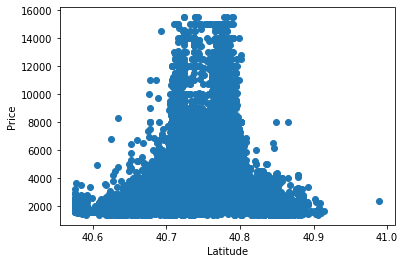

In [ ]:
# And let's make scatter plots to take a peak at our data
# Our feature will be latitude

import matplotlib.pyplot as plt

# Latitude (feature) and price (target)
plt.scatter(df2['latitude'],
            df2['price'])
plt.xlabel('Latitude')
plt.ylabel('Price');

In [ ]:
# Now, we can do a t-t-s with our new dataframe

# 1. Define features and target
# Our features will be latitude and longitude

from sklearn.model_selection import train_test_split

y = df2['price']
X = df[['latitude',
        'longitude']]

print('y Shape: ', y.shape)
print('X shape: ', X.shape)


y Shape:  (48817,)
X shape:  (48817, 2)


In [ ]:
# 2. Split data into TRAINING and VALIDATION sets
cutoff = '2016-06'
mask = X.index < '2016-06'

# training
X_train, y_train = X.loc[mask], y.loc[mask]

# validation
X_val, y_val = X.loc[~mask], y.loc[~mask]

##  2. Engineer at least two new features. (See below for explanation & ideas.)

In [ ]:
# 3. Establish baseline

# What's the y_train mean?
print('y_train mean: ', y_train.mean())

y_train mean:  3575.604007034292


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


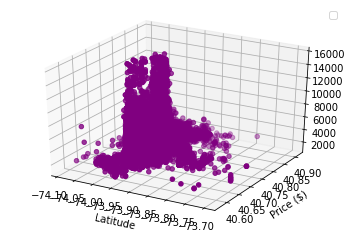

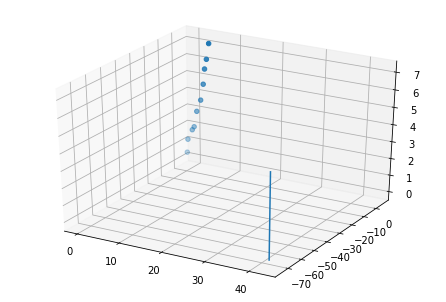

In [ ]:
# Let's plot our baseline

# for legibility, create new list for features
col1 = 'latitude'
col2 = 'longitude'
y_pred = [y_train.mean()]*len(X_train)

fig, ax = figsize=(20,14)
ax = plt.axes(projection="3d")

ax.scatter3D(X_train[[col2]], X_train[[col1]], y_train, color='purple')
# plt.plot(X_train,
#             y_pred,
#             color='black',
#             label='Baseline Model')
plt.xlabel('Latitude')
plt.ylabel('Price ($)')
plt.legend();

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pts = np.add.accumulate(np.random.random((10,3)))
x,y,z = pts.T

# this will find the slope and x-intercept of a plane
# parallel to the y-axis that best fits the data
A_xz = np.vstack((X_train[col1], np.ones(len(X_train[col1])))).T
m_xz, c_xz = np.linalg.lstsq(A_xz, y_train)[0]

# again for a plane parallel to the x-axis
A_yz = np.vstack((X_train[col2], np.ones(len(X_train[col2])))).T
m_yz, c_yz = np.linalg.lstsq(A_yz, y_train)[0]

def lin(z):
    x = (z - c_xz)/m_xz
    y = (z - c_yz)/m_yz
    return x,y

fig = plt.figure()
ax = Axes3D(fig)
zz = np.linspace(0,5)
xx,yy = lin(zz)
ax.scatter(x, y, z)
ax.plot(xx,yy,zz)

plt.show()

In [ ]:
# Now, we can determine our mean absolute error
from sklearn.metrics import mean_absolute_error

print('Baseline MAE: ', mean_absolute_error(y_train, y_pred))

Baseline MAE:  1201.8811133682555


In [ ]:
# 4. Build Regression Model
from sklearn.linear_model import LinearRegression

# Steps to doing a train test split

  # 1. Instantiate model
model = LinearRegression()

  # 2. Fit model to data
model.fit(X_train, y_train)

  # 3. Make predictions
y_pred = model.predict(X_train)

In [ ]:
# Now, let's plot!
col = 'latitude'

plt.scatter(X_train[col], y_train)
plt.plot(X_train[col],
         y_pred,
         color='red',
         label='Regression Model')
plt.axhline(y_train.mean(),
            color='black',
            linestyle='--')
plt.xlabel('Latitude')
plt.ylabel('Price ($)')
plt.legend();

## 3. Get the model's coefficients and intercept.

In [ ]:
# Check Metrics
# This is a super important step!

print('Training MAE: ', mean_absolute_error(y_train, model.predict(X_train)))
print('Validation MAE: ', mean_absolute_error(y_val, model.predict(X_val)))

Training MAE:  1147.1493278231892
Validation MAE:  1139.700457630833
